## LLM for alternative text generation
Le texte alternatif, conçu pour remplacer les images et améliorer l’accessibilité des personnes aveugles ou malvoyantes (BLV), diffère des légendes d’images qui servent à les compléter. Bien que des progrès aient été réalisés dans la génération automatique de légendes, ces approches ne répondent souvent pas aux besoins spécifiques d’accessibilité.  

**AD2AT** est un jeu de données dédié à la génération de texte alternatif. Ce projet  compar les performances de modèles multimodaux basés sur des grands modèles de langage (LLM), démontrant que les modèles spécialisés en légendes d’images ne sont pas optimaux pour cette tâche. Une analyse de leurs limites a également été effectuée.


#### Données 
Le corpus AD2AT-VIW propose des audiodescriptions en anglais, espagnol et catalan, réalisées, pour le film de 14 minutes *"What Happens While"*. 
Parmi ces audiodescriptions, nous avons sélectionné 10 versions en anglais.


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class AD2ATDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None):
        """
        Initialise le dataset AD2AT.

        Args:
            images_dir (str): Chemin vers le dossier contenant les images.
            annotations_file (str): Chemin vers le fichier CSV contenant les annotations.
            transform (callable, optional): Transformations à appliquer sur les images.
        """
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_file, sep=";", encoding='latin1')
        self.transform = transform

    def __len__(self):
        """Retourne la taille du dataset."""
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Retourne un exemple du dataset.

        Args:
            idx (int): Index de l'exemple.

        Returns:
            dict: Dictionnaire contenant l'image, le texte alternatif et le contexte.
        """
        row = self.annotations.iloc[idx]
        image_path = os.path.join(self.images_dir, row["image_path"])
        alt_text = row["altText"]
        context = row["context"]

        # Chargement de l'image
        image = Image.open(image_path).convert("RGB")

        # Appliquer les transformations si spécifiées
        if self.transform:
            image = self.transform(image)

        return {"image": image, "alt_text": alt_text, "context": context}

#### Visualization et analyse

In [3]:
import matplotlib.pyplot as plt

def visualize_example(dataset, image_name):
    """
    Visualise une image et ses textes alternatifs associés.

    Args:
        dataset (AD2ATDataset): Le dataset AD2AT.
        image_name (str): Nom du fichier image à visualiser.
    """
    # Filtrer les annotations pour l'image spécifiée
    examples = dataset.annotations[dataset.annotations["image_path"] == image_name]

    if examples.empty:
        print(f"Aucune annotation trouvée pour l'image {image_name}")
        return

    image_path = os.path.join(dataset.images_dir, image_name)
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image: {image_name}")
    plt.show()
    for idx, row in examples.iterrows():
        print(f"Texte alternatif {idx + 1}: {row['altText']}")


In [4]:
def analyze_dataset(dataset):
    """
    Analyse les caractéristiques du dataset AD2AT.

    Args:
        dataset (AD2ATDataset): Le dataset AD2AT.

    Returns:
        dict: Résumé des statistiques du dataset.
    """
    num_samples = len(dataset)
    text_lengths = dataset.annotations["altText"].str.len()
    num_alt_texts = dataset.annotations["image_path"].value_counts()

    stats = {
        "Nombre total d'images": len(num_alt_texts),
        "Nombre total d'exemples": num_samples,
        "Longueur moyenne des textes alternatifs": text_lengths.mean(),
        "Nombre moyen de textes alternatifs par image": num_alt_texts.mean(),
    }
    return stats

##### Objectives :
Charger et analyser le jeu de données AD2AT pour extraire des statistiques clés (longueur moyenne des textes alternatifs, nombre de descriptions par image) et visualiser des exemples combinant images, textes alternatifs et informations contextuelles.

Statistiques du dataset: {"Nombre total d'images": 28, "Nombre total d'exemples": 226, 'Longueur moyenne des textes alternatifs': np.float64(70.74553571428571), 'Nombre moyen de textes alternatifs par image': np.float64(8.071428571428571)}


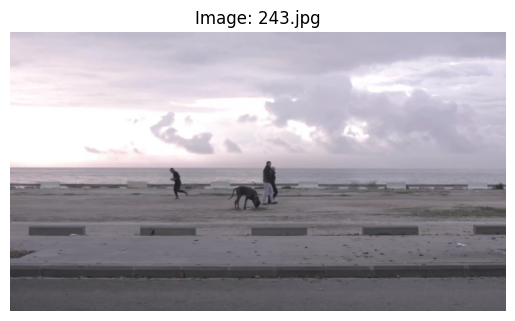

Texte alternatif 1: On an overcast day, a man and a woman walk by the seaside with a large, lanky dog. A jogger passes them in the opposite direction. The dog sniffs the ground.
Texte alternatif 2: A nearly-empty beach beside a sea. A couple wears jackets as they stroll with their large Great Dane. A male runner jogs past. The dog sniffs the sand.
Texte alternatif 3: In the distance, a couple walk their dog along an urban beach. They pass a jogger running in the opposite direction. The dog sniffs at something on the sand.
Texte alternatif 4: A road running along by the sea. A couple walk their dog on the flat beach and a jogger runs past. The sky above is pale and dappled with light grey clouds.
Texte alternatif 5: A sandy promenade at the seaside in pale dawn light. A man in a tracksuit jogs past a couple with a large dog, which sniffs at something in the sand.
Texte alternatif 6: Daytime. A pale grey seafront. A couple walk their dog along a sandy promenade, passing a jogger going in

In [5]:
dataset = AD2ATDataset(images_dir="AD2AT/images", annotations_file="AD2AT/annotations.csv")
stats = analyze_dataset(dataset)
print("Statistiques du dataset:", stats)
visualize_example(dataset, "243.jpg")

### 2. Modèles: BLIP et FuseCap pour alternative text generation

* **Méthodes de génération :** Implémenter des méthodes pour générer des descriptions textuelles alternatives pour des images à l'aide de deux modèles multimodaux préentraînés : BLIP et FuseCap
* **Évaluation des performances :** Développer une fonction pour calculer les métriques d’évaluation des textes générés  à l’aide de métriques telles que BLEU, ROUGE et METEOR.

#### 2.1. BLIP (Bootstrapped Language-Image Pre-training)
BLIP est un modèle multimodal detat d'art conçu pour comprendre et générer des relations entre images et textes. En s'appuyant sur des encodeurs d'images (comme ViT) et de texte (comme Transformers), il excelle dans des tâches telles que la génération de légendes, les questions visuelles et la recherche image-texte.

In [6]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_alt_text_blip(dataset):
    """
    Génère des textes alternatifs pour les images à l'aide du modèle BLIP.

    Args:
        dataset (AD2ATDataset): Le dataset AD2AT.

    Returns:
        list: Liste des prédictions sous forme de dictionnaires.
    """
    results = []
    for idx in range(len(dataset)):
        example = dataset[idx]
        inputs = processor(images=example["image"], return_tensors="pt").to(device)
        output = model.generate(**inputs)
        generated_text = processor.decode(output[0], skip_special_tokens=True)
        results.append({
            "image_path": dataset.annotations.iloc[idx]["image_path"],
            "generated_text": generated_text,
            "ground_truths": dataset.annotations[dataset.annotations["image_path"] == dataset.annotations.iloc[idx]["image_path"]]["altText"].tolist()
        })
    return results


C:\Users\EL mahjoubi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\EL mahjoubi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\EL mahjoubi\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see http

C:\Users\EL mahjoubi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:651: UserWarning: Not enough free disk space to download the file. The expected file size is: 989.72 MB. The target location C:\Users\EL mahjoubi\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base\blobs only has 105.29 MB free disk space.
  warnings.warn(


#### 2.2. FuseCap
FuseCap est un modèle multimodal avancé pour générer des légendes d’images, combinant encodeurs visuels et décodeurs textuels pour des descriptions précises et adaptées aux besoins d’accessibilité.

In [7]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor_fusecap = BlipProcessor.from_pretrained("noamrot/FuseCap")
model_fusecap = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap").to(device)

def generate_alt_text_fusecap(dataset):
    """
    Génère des textes alternatifs pour les images avec le modèle FuseCap.

    Args:
        dataset (AD2ATDataset): Le dataset AD2AT.

    Returns:
        list: Liste des prédictions sous forme de dictionnaires.
        
    """
    results = []
    for idx in range(len(dataset)):
        example = dataset[idx]
        text = "a picture of "
        inputs = processor_fusecap(example["image"], text, return_tensors="pt").to(device)
        output = model_fusecap.generate(**inputs)
        generated_text = processor_fusecap.decode(output[0], skip_special_tokens=True)
        results.append({
            "image_path": dataset.annotations.iloc[idx]["image_path"],
            "generated_text": generated_text,
            "ground_truths": dataset.annotations[dataset.annotations["image_path"] == dataset.annotations.iloc[idx]["image_path"]]["altText"].tolist()
        })
    return results

C:\Users\EL mahjoubi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\EL mahjoubi\.cache\huggingface\hub\models--noamrot--FuseCap. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


#### 2.3. Evaluation
Nous allons créer une fonction qui calcule les métriques BLEU, ROUGE et METEOR, permettant d'évaluer la similarité entre les prédictions textuelles et les textes générés.

In [8]:
from evaluate import load

def evaluate_metrics(predictions, references):
    """
    Évalue les prédictions avec différentes métriques.

    Args:
        predictions (list): Liste des textes générés.
        references (list of list): Liste des listes de références.

    Returns:
        dict: Dictionnaire des scores pour chaque métrique.
    """
    metrics = ["bleu", "rouge", "meteor"]
    scores = {}
    for metric_name in metrics:
        metric = load(metric_name)
        score = metric.compute(predictions=predictions, references=references)
        scores[metric_name] = score
    return scores

In [9]:
def save_results(results, output_file):
    """
    Sauvegarde les résultats sous forme de fichier CSV.

    Args:
        results (list): Liste des résultats.
        output_file (str): Chemin vers le fichier de sortie.
    """
    pd.DataFrame(results).to_csv(output_file, index=False)


In [10]:
import json

def save_scores(scores, output_file):
    """
    Enregistre les scores dans un fichier JSON.

    Args:
        scores (dict): Dictionnaire contenant les scores des métriques.
        output_file (str): Chemin vers le fichier de sortie (fichier JSON).
    """
    with open(output_file, "w") as f:
        json.dump(scores, f, indent=4)
    print(f"Scores enregistrés dans {output_file}")

In [11]:
def print_generated_alt_text(results, image_name):
    """
    This function prints the generated alternative texts for a specific image, comparing results from different models.
    
    Args:
        results (dict): A dictionary containing the model names as keys and a list of generated alternative texts as values.
        image_name (str): The name of the image (e.g., '243.jpg') for which the texts should be displayed.
    """
    print(f"Generated alternative texts for image: {image_name}\n")
    
    # Charger l'image
    image_path = os.path.join(dataset.images_dir, image_name)
    image = Image.open(image_path).convert("RGB")

    # Afficher l'image
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image: {image_name}")
    plt.show()

    i = 0
    for res in results:
        if res["image_path"] == image_name:
            print("  Alt-text "+str(i+1)+" : "+res["generated_text"])
            i = i + 1

#### 2.4 Resultats

[nltk_data] Downloading package wordnet to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Scores enregistrés dans scores_blip.json
['a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'a man walking a dog on the beach', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'what happens wine logo', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bmw z4 coupe test drive video', 'bm

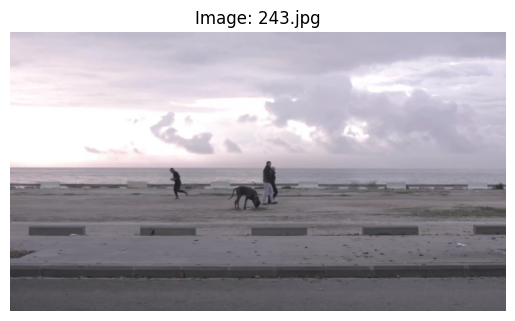

  Alt-text 1 : a man walking a dog on the beach
  Alt-text 2 : a man walking a dog on the beach
  Alt-text 3 : a man walking a dog on the beach
  Alt-text 4 : a man walking a dog on the beach
  Alt-text 5 : a man walking a dog on the beach
  Alt-text 6 : a man walking a dog on the beach
  Alt-text 7 : a man walking a dog on the beach
  Alt-text 8 : a man walking a dog on the beach
  Alt-text 9 : a man walking a dog on the beach
  Alt-text 10 : a man walking a dog on the beach


[nltk_data] Downloading package wordnet to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Scores enregistrés dans scores_fusecap.json


In [13]:
import nltk
import os

#nltk_data_dir = r"C:\Users\EL mahjoubi\Desktop\text-generation\nltk_data"
#if not os.path.exists(nltk_data_dir):
#    os.makedirs(nltk_data_dir)

#nltk.data.path.append(nltk_data_dir)

#nltk.download('punkt', download_dir=nltk_data_dir)

results_blip = generate_alt_text_blip(dataset)
save_results(results_blip, "results_blip.csv")
scores_blip = evaluate_metrics(
    [res["generated_text"] for res in results_blip],
    [res["ground_truths"] for res in results_blip]
)
save_scores(scores_blip, "scores_blip.json")
print([res["generated_text"] for res in results_blip])
print_generated_alt_text(results_blip, "243.jpg")

results_fusecap = generate_alt_text_fusecap(dataset)
save_results(results_fusecap, "results_fusecap.csv")
scores_fusecap = evaluate_metrics(
    [res["generated_text"] for res in results_fusecap],
    [res["ground_truths"] for res in results_fusecap]
)
save_scores(scores_fusecap, "scores_fusecap.json")


## 3. Integration du contexte
Sans contexte, le texte alternatif généré peut offrir une description plus générale, risquant de manquer la pertinence spécifique à l’histoire.  
Pour intégrer le contexte dans BLIP, on peut enrichir les entrées du modèle avec des informations contextuelles afin de mieux comprendre le rôle de l’image dans une séquence et produire des textes alternatifs plus précis.  


#### 3.1 BLIP avec Context

In [14]:
def generate_alt_text_blip_with_context(dataset):
    """
    Génère des textes alternatifs en tenant compte du contexte.

    Args:
        dataset (AD2ATDataset): Le dataset AD2AT.

    Returns:
        list: Liste des prédictions sous forme de dictionnaires.
    """
    results = []
    for idx in range(len(dataset)):
        example = dataset[idx]
        context = example["context"]
        if not isinstance(context, str):
          context = str(context) if context else ""
        inputs = processor(images=example["image"], text=context, return_tensors="pt").to(device)
        output = model.generate(**inputs, max_length=500)
        generated_text = processor.decode(output[0], skip_special_tokens=True)
        results.append({
            "image_path": dataset.annotations.iloc[idx]["image_path"],
            "generated_text": generated_text,
            "ground_truths": dataset.annotations[dataset.annotations["image_path"] == dataset.annotations.iloc[idx]["image_path"]]["altText"].tolist()
        })
    return results

#### 3.2 Resultats avce contexte

In [15]:
results_blip_context = generate_alt_text_blip_with_context(dataset)
save_results(results_blip_context, "results_blip_with_context.csv")
scores_blip_context = evaluate_metrics(
    [res["generated_text"] for res in results_blip_context],
    [res["ground_truths"] for res in results_blip_context]
)
save_scores(scores_blip_context, "scores_blip_with_context.json")

[nltk_data] Downloading package wordnet to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\EL
[nltk_data]     mahjoubi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Scores enregistrés dans scores_blip_with_context.json


### 4 Utilisation d'InstructBLIP et du Prompting pour Orienter la Génération de Textes Alternatifs  
* Tester différents contextes et prompts et  comparer les performances avec les modèles précédents  

#### InstructBLIP

InstructBLIP is an advanced large language model that extends BLIP by leveraging instruction-based fine-tuning. 

In [16]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration

def generate_alt_text_instructBlip(dataset, prompt, include_context=False):
    """
    Génère des textes alternatifs avec ou sans contexte.

    Args:
        dataset (list[dict]): Jeu de données.
        prompt (str): Prompt pour guider la génération.
        include_context (bool): Si True, inclut le contexte dans le prompt.

    Returns:
        list[dict]: Liste des résultats avec les textes générés.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor_instructBlip = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b")
    model_instructBlip = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

    results = []

    for idx in range(len(dataset)):
        example = dataset[idx]  
        text = prompt
        if include_context:
            text += f" Context: {example['context']}"
        inputs = processor(images=example["image"], text=text, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_length=500)
        generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

        results.append({
            "image_path": dataset.annotations.iloc[idx]["image_path"],
            "generated_text": generated_text,
            "ground_truths": dataset.annotations[dataset.annotations["image_path"] == dataset.annotations.iloc[idx]["image_path"]]["altText"].tolist()
        })

    return results


#### Prompting 

In [25]:
prompt = "Write alternative text for this image. Be concise while providing sufficient information for visually impaired people."
    
results_instructBlip = generate_alt_text_instructBlip(dataset, prompt, include_context=False)
save_results(results_instructBlip, "results_instructBlip.csv")
scores_instructBlip = evaluate_metrics(
    [res["generated_text"] for res in results_instructBlip],
    [res["ground_truths"] for res in results_instructBlip]
)
save_scores(scores_instructBlip, "scores_instructBlip.json")

results_instructBlip_context = generate_alt_text_instructBlip(dataset, prompt, include_context=True)
save_results(results_instructBlip_context, "results_instructBlip_context.csv")
scores_instructBlip_context = evaluate_metrics(
    [res["generated_text"] for res in results_instructBlip_context],
    [res["ground_truths"] for res in results_instructBlip_context]
)
save_scores(scores_instructBlip_context, "scores_instructBlip_context.json")

  warnings.warn(
Error while downloading from https://cdn-lfs.hf.co/repos/fa/52/fa523532eb768e2126266fb7e4f5eeac3f3069f77eab6fb9ef6ef02b07cc2ed5/da825eee67c127052d38bc429e077571dfba65860dabbbd84d9fdaf5cd496666?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model-00001-of-00004.safetensors%3B+filename%3D%22model-00001-of-00004.safetensors%22%3B&Expires=1736982898&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjk4Mjg5OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9mYS81Mi9mYTUyMzUzMmViNzY4ZTIxMjYyNjZmYjdlNGY1ZWVhYzNmMzA2OWY3N2VhYjZmYjllZjZlZjAyYjA3Y2MyZWQ1L2RhODI1ZWVlNjdjMTI3MDUyZDM4YmM0MjllMDc3NTcxZGZiYTY1ODYwZGFiYmJkODRkOWZkYWY1Y2Q0OTY2NjY%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=eh2lnOah2g4LiojSWK2KA8OZAuzpV75z0P4vpWx6VKz6zfaCkPIhRGOzXoS%7EAGe2kOjpHdNG9y2YA70Vj9sdEfd%7E0DtM-Kw1ApXJh%7E153w5Xyv3pL3a6O3pUJaP%7Eww5-%7EOs3gpCqLW89hI0zkWAXRdc7p9FVPzz8s3KXD0mzK10FzJtpZK6i2iigvofiDVwKjySFSe1u3kRD8LRbip

OSError: [Errno 28] No space left on device

### Evaluation 

In [19]:
import numpy as np

def reformat_scores(raw_scores):
    """
    Reformate les scores bruts dans un format simplifié.

    Args:
        raw_scores (dict): Dictionnaire des scores bruts.

    Returns:
        dict: Dictionnaire reformatté avec des clés simplifiées et des valeurs arrondies.
    """
    formatted_scores = {
        "BLEU": round(raw_scores["bleu"]["bleu"], 3),
        "ROUGE-1": round(float(raw_scores["rouge"]["rouge1"]), 3),
        "ROUGE-2": round(float(raw_scores["rouge"]["rouge2"]), 3),
        "ROUGE-L": round(float(raw_scores["rouge"]["rougeL"]), 3),
        "ROUGE-LSUM": round(float(raw_scores["rouge"]["rougeLsum"]), 3),
        "METEOR": round(float(raw_scores["meteor"]["meteor"]), 3),
    }
    return formatted_scores


In [21]:
from tabulate import tabulate

def print_scores(scores):
    """
    Affiche les scores sous forme de tableau Markdown.

    Args:
        scores (dict): Dictionnaire des scores au format {"methode": {"metric": value}}.
    """
    
    headers = ["Méthode"] + list(next(iter(scores.values())).keys())  # Récupère les métriques depuis une méthode
    
    table_data = [
        [method] + [f"{value:.4f}" for value in method_scores.values()]
        for method, method_scores in scores.items()
    ]
    
    table = tabulate(table_data, headers=headers, tablefmt="github")
    print(table)

In [26]:
all_scores = {
    "BLIP": reformat_scores(scores_blip),
    "BLIP + Contexte": reformat_scores(scores_blip_context),
    "FuseCap": reformat_scores(scores_fusecap),
    #"instructBlip":  reformat_scores(scores_instructBlip),
    #"instructBlip + Contexte":  reformat_scores(scores_instructBlip_context),
}
print_scores(all_scores)

| Méthode         |   BLEU |   ROUGE-1 |   ROUGE-2 |   ROUGE-L |   ROUGE-LSUM |   METEOR |
|-----------------|--------|-----------|-----------|-----------|--------------|----------|
| BLIP            |  0.059 |     0.333 |     0.155 |     0.308 |        0.308 |    0.241 |
| BLIP + Contexte |  0.037 |     0.181 |     0.04  |     0.145 |        0.145 |    0.235 |
| FuseCap         |  0.055 |     0.281 |     0.105 |     0.237 |        0.236 |    0.269 |


1. BLIP :  
 obtient de bonnes performances sur ROUGE-1 et ROUGE-L, mais montre des scores plus faibles pour BLEU et ROUGE-2. Cela indique une capacité modérée à générer des textes globalement pertinents.

2. BLIP + Contexte : 
   Ajouter le contexte à BLIP semble diminuer les scores sur toutes les métriques par rapport à la version standard. Cela pourrait suggérer que l’intégration du contexte n’a pas été optimisée ou qu’elle a introduit une complexité non maîtrisée dans la génération.

3. FuseCap :
    montre des scores légèrement inférieurs à BLIP pour certaines métriques (comme BLEU et ROUGE-1), mais il obtient le meilleur score METEOR (0.269), ce qui reflète une meilleure correspondance globale et une fluidité accrue des descriptions générées.

**Résumé :**  
- BLIP est globalement le plus performant, mais FuseCap montre une meilleure fluidité (METEOR).  
- L’ajout de contexte à BLIP semble nuire à ses performances actuelles, suggérant qu’une optimisation supplémentaire est nécessaire.